In [1]:
! pip install chart-studio

     |████████████████████████████████| 71kB 5.1MB/s 


Importing all the necessary items

In [865]:
import pandas as pd
import numpy as np
import scipy as sc
from scipy.stats import kurtosis, skew, poisson
import statistics as stat
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from datetime import datetime
import plotly.graph_objs as go
import plotly.express as px
import seaborn as sns
from matplotlib import figure
from matplotlib.dates import DateFormatter
import plotly.io as pio
from IPython.display import Image
from scipy.stats.distributions import poisson


Reading all the data.

In [866]:
super_dataset = pd.read_csv('../../../../data/stage_I/superDataset.csv')
cases = pd.read_csv("../../../../data/stage_I/covid_confirmed_usafacts.csv", delimiter=",")
deaths = pd.read_csv("../../../../data/stage_I/covid_deaths_usafacts.csv", delimiter=",")
population = pd.read_csv("../../../../data/stage_I/covid_county_population_usafacts.csv", delimiter=",")
beds = pd.read_csv("../../../../data/stage_I/Definitive_Healthcare _USA_Hospital_Beds.csv", delimiter=",")

# Task 1


## Generate weekly statistics (mean, median, mode) for number of new cases and deaths across a specific state.

w_cases is a variable for the total cases of the state of washington.

In [958]:
w_cases = cases[cases['State']=='WA'].fillna(0)
w_deaths = deaths[deaths['State']=='WA'].fillna(0)
w_people = population[population['State']=='WA'].fillna(0)
w_population = w_people['population'].sum()

Dropping the statefips and getting the sem

In [959]:
w_cases = w_cases.drop(columns=['StateFIPS'])
w_deaths = w_deaths.drop(columns=['StateFIPS'])
w_cases = w_cases.set_index(['countyFIPS','County Name','State'])
total_cases_sum = w_cases.sum()
w_deaths = w_deaths.set_index(['countyFIPS','County Name','State'])
total_deaths_sum = w_deaths.sum()

Below I am creating a dataframe and adding columns for mean median etc.

# Mode is the set of values that appears most in a set of data. As the cases and deaths are very random, there is no point in calculating the mode. Hence, we will not be calculating mode here.

In [960]:
total_cases_sum = total_cases_sum.to_frame().reset_index()
total_deaths_sum = total_deaths_sum.to_frame().reset_index()
total_cases_sum = total_cases_sum.rename(columns = { 'index' : 'date'})
total_cases_sum = total_cases_sum.rename(columns = { 0 : 'total_cases'})
total_deaths_sum = total_deaths_sum.rename(columns = { 'index' : 'date'})
total_deaths_sum = total_deaths_sum.rename(columns = { 0 : 'total_deaths'})
total_cases_sum[['year', 'week', 'day']] = pd.DataFrame(total_cases_sum.date.apply(lambda x: datetime.strptime(x, "%Y-%m-%d").isocalendar()).to_list(), index=total_cases_sum.index)
total_deaths_sum[['year', 'week', 'day']] = pd.DataFrame(total_deaths_sum.date.apply(lambda x: datetime.strptime(x, "%Y-%m-%d").isocalendar()).to_list(), index=total_deaths_sum.index)
total_cases_sum['mean_cases']= total_cases_sum['total_cases']
total_cases_sum['median_cases'] = total_cases_sum['total_cases']
total_deaths_sum['mean_deaths']= total_deaths_sum['total_deaths']
total_deaths_sum['median_deaths'] = total_deaths_sum['total_deaths']


Below is a table for task 2.

In [961]:
total_cases_sum['daily_total_norm'] = ((total_cases_sum.total_cases/w_population)*100000) + 1 
total_cases_sum['log_total_norm'] = np.log(total_cases_sum['daily_total_norm'].replace(-np.inf,0))

total_deaths_sum['daily_total_norm'] = ((total_deaths_sum.total_deaths/w_population)*100000) + 1 
total_deaths_sum['log_total_norm'] = np.log(total_deaths_sum['daily_total_norm'].replace(-np.inf,0))

daily_trends_cases = total_cases_sum.copy()
daily_trends_deaths = total_deaths_sum.copy()

Getting dates and calcualting the weeks below.

In [962]:
data_weekly = total_cases_sum.groupby(['year', 'week']).mean()[["mean_cases"]].apply(lambda x: np.round(x).astype("int")).reset_index()
data_weekly['date'] = data_weekly.apply(lambda x: str(datetime.strptime("{0} {1} 2".format(x[0], x[1]), "%Y %W %w").date()), axis=1)
data_weekly['total_cases']=total_cases_sum['total_cases']

data_weekly_deaths = total_deaths_sum.groupby(['year', 'week']).mean()[["mean_deaths"]].apply(lambda x: np.round(x).astype("int")).reset_index()
data_weekly_deaths['date'] = data_weekly_deaths.apply(lambda x: str(datetime.strptime("{0} {1} 2".format(x[0], x[1]), "%Y %W %w").date()), axis=1)
data_weekly_deaths['total_deaths']=total_deaths_sum['total_deaths']

data_weekly_median = total_cases_sum.groupby(['year', 'week']).median()[["median_cases"]].apply(lambda x: np.round(x).astype("int")).reset_index()
data_weekly_median['date'] = data_weekly_median.apply(lambda x: str(datetime.strptime("{0} {1} 2".format(x[0], x[1]), "%Y %W %w").date()), axis=1)
data_weekly_median['total_cases']=total_cases_sum['total_cases']

data_weekly_median_deaths = total_deaths_sum.groupby(['year', 'week']).median()[["median_deaths"]].apply(lambda x: np.round(x).astype("int")).reset_index()
data_weekly_median_deaths['date'] = data_weekly_median_deaths.apply(lambda x: str(datetime.strptime("{0} {1} 2".format(x[0], x[1]), "%Y %W %w").date()), axis=1)
data_weekly_median_deaths['total_deaths']=total_deaths_sum['total_deaths']

Merging the table below. 
# We have the weekly statistics below of the state of Washington.

In [963]:
main_data_wa = pd.merge(data_weekly,data_weekly_median)
main_data_wa = pd.merge(main_data_wa,data_weekly_deaths)
main_data_wa = pd.merge(main_data_wa, data_weekly_median_deaths)
main_data_wa

,year,week,mean_cases,date,total_cases,median_cases,mean_deaths,total_deaths,median_deaths
0,2020,4,1,2020-01-28,1,1,0,0,0
1,2020,5,1,2020-02-04,1,1,0,0,0
2,2020,6,1,2020-02-11,1,1,0,0,0
3,2020,7,1,2020-02-18,1,1,0,0,0
4,2020,8,1,2020-02-25,1,1,0,0,0
...,...,...,...,...,...,...,...,...,...
56,2021,7,331586,2021-02-16,1187,332007,4774,66,4803
57,2021,8,337608,2021-02-23,1376,337655,4924,74,4942
58,2021,9,342917,2021-03-02,1524,343091,5021,83,5034
59,2021,10,347682,2021-03-09,1790,347132,5108,93,5104


## Compare the data against other states. (normalize by population)

Repeating the steps that I did above to get the data of washington.


In [964]:
p_cases = cases[cases['State']=='PA'].fillna(0)
p_deaths = deaths[deaths['State']=='PA'].fillna(0)
p_cases = p_cases.drop(columns=['StateFIPS'])
p_deaths = p_deaths.drop(columns=['StateFIPS'])
p_cases = p_cases.set_index(['countyFIPS','County Name','State'])
total_cases_sum_pa = p_cases.sum()
p_deaths = p_deaths.set_index(['countyFIPS','County Name','State'])
total_deaths_sum_pa = p_deaths.sum()
total_cases_sum_pa = total_cases_sum_pa.to_frame().reset_index()
total_deaths_sum_pa = total_deaths_sum_pa.to_frame().reset_index()
total_cases_sum_pa = total_cases_sum_pa.rename(columns = { 'index' : 'date'})
total_cases_sum_pa = total_cases_sum_pa.rename(columns = { 0 : 'total_cases_pa'})
total_deaths_sum_pa = total_deaths_sum_pa.rename(columns = { 'index' : 'date'})
total_deaths_sum_pa = total_deaths_sum_pa.rename(columns = { 0 : 'total_deaths_pa'})
p_people = population[population['State']=='PA'].fillna(0)
p_population = p_people['population'].sum()

c_cases = cases[cases['State']=='CA'].fillna(0)
c_deaths = deaths[deaths['State']=='CA'].fillna(0)
c_cases = c_cases.drop(columns=['StateFIPS'])
c_deaths = c_deaths.drop(columns=['StateFIPS'])
c_cases = c_cases.set_index(['countyFIPS','County Name','State'])
total_cases_sum_ca = c_cases.sum()
c_deaths = c_deaths.set_index(['countyFIPS','County Name','State'])
total_deaths_sum_ca = c_deaths.sum()
total_cases_sum_ca = total_cases_sum_ca.to_frame().reset_index()
total_deaths_sum_ca = total_deaths_sum_ca.to_frame().reset_index()
total_cases_sum_ca = total_cases_sum_ca.rename(columns = { 'index' : 'date'})
total_cases_sum_ca = total_cases_sum_ca.rename(columns = { 0 : 'total_cases_ca'})
total_deaths_sum_ca = total_deaths_sum_ca.rename(columns = { 'index' : 'date'})
total_deaths_sum_ca = total_deaths_sum_ca.rename(columns = { 0 : 'total_deaths_ca'})
c_people = population[population['State']=='CA'].fillna(0)
c_population = c_people['population'].sum()

g_cases = cases[cases['State']=='GA'].fillna(0)
g_deaths = deaths[deaths['State']=='GA'].fillna(0)
g_cases = g_cases.drop(columns=['StateFIPS'])
g_deaths = g_deaths.drop(columns=['StateFIPS'])
g_cases = g_cases.set_index(['countyFIPS','County Name','State'])
total_cases_sum_ga = g_cases.sum()
g_deaths = g_deaths.set_index(['countyFIPS','County Name','State'])
total_deaths_sum_ga = g_deaths.sum()
total_cases_sum_ga = total_cases_sum_ga.to_frame().reset_index()
total_deaths_sum_ga = total_deaths_sum_ga.to_frame().reset_index()
total_cases_sum_ga = total_cases_sum_ga.rename(columns = { 'index' : 'date'})
total_cases_sum_ga = total_cases_sum_ga.rename(columns = { 0 : 'total_cases_ga'})
total_deaths_sum_ga = total_deaths_sum_ga.rename(columns = { 'index' : 'date'})
total_deaths_sum_ga = total_deaths_sum_ga.rename(columns = { 0 : 'total_deaths_ga'})
g_people = population[population['State']=='GA'].fillna(0)
g_population = g_people['population'].sum()

i_cases = cases[cases['State']=='IA'].fillna(0)
i_deaths = deaths[deaths['State']=='IA'].fillna(0)
i_cases = i_cases.drop(columns=['StateFIPS'])
i_deaths = i_deaths.drop(columns=['StateFIPS'])
i_cases = i_cases.set_index(['countyFIPS','County Name','State'])
total_cases_sum_ia = i_cases.sum()
i_deaths = i_deaths.set_index(['countyFIPS','County Name','State'])
total_deaths_sum_ia = i_deaths.sum()
total_cases_sum_ia = total_cases_sum_ia.to_frame().reset_index()
total_deaths_sum_ia = total_deaths_sum_ia.to_frame().reset_index()
total_cases_sum_ia = total_cases_sum_ia.rename(columns = { 'index' : 'date'})
total_cases_sum_ia = total_cases_sum_ia.rename(columns = { 0 : 'total_cases_ia'})
total_deaths_sum_ia = total_deaths_sum_ia.rename(columns = { 'index' : 'date'})
total_deaths_sum_ia = total_deaths_sum_ia.rename(columns = { 0 : 'total_deaths_ia'})
i_people = population[population['State']=='IA'].fillna(0)
i_population = i_people['population'].sum()

m_cases = cases[cases['State']=='MA'].fillna(0)
m_deaths = deaths[deaths['State']=='MA'].fillna(0)
m_cases = m_cases.drop(columns=['StateFIPS'])
m_deaths = m_deaths.drop(columns=['StateFIPS'])
m_cases = m_cases.set_index(['countyFIPS','County Name','State'])
total_cases_sum_ma = m_cases.sum()
m_deaths = m_deaths.set_index(['countyFIPS','County Name','State'])
total_deaths_sum_ma = m_deaths.sum()
total_cases_sum_ma = total_cases_sum_ma.to_frame().reset_index()
total_deaths_sum_ma = total_deaths_sum_ma.to_frame().reset_index()
total_cases_sum_ma = total_cases_sum_ma.rename(columns = { 'index' : 'date'})
total_cases_sum_ma = total_cases_sum_ma.rename(columns = { 0 : 'total_cases_ma'})
total_deaths_sum_ma = total_deaths_sum_ma.rename(columns = { 'index' : 'date'})
total_deaths_sum_ma = total_deaths_sum_ma.rename(columns = { 0 : 'total_deaths_ma'})
m_people = population[population['State']=='MA'].fillna(0)
m_population = m_people['population'].sum()

Getting the weeks for all the 5 states below, as I did above for washington.

In [965]:
total_cases_sum_pa[['year', 'week', 'day']] = pd.DataFrame(total_cases_sum_pa.date.apply(lambda x: datetime.strptime(x, "%Y-%m-%d").isocalendar()).to_list(), index=total_cases_sum_pa.index)
total_cases_sum_ca[['year', 'week', 'day']] = pd.DataFrame(total_cases_sum_ca.date.apply(lambda x: datetime.strptime(x, "%Y-%m-%d").isocalendar()).to_list(), index=total_cases_sum_ca.index)
total_cases_sum_ga[['year', 'week', 'day']] = pd.DataFrame(total_cases_sum_ga.date.apply(lambda x: datetime.strptime(x, "%Y-%m-%d").isocalendar()).to_list(), index=total_cases_sum_ga.index)
total_cases_sum_ia[['year', 'week', 'day']] = pd.DataFrame(total_cases_sum_ia.date.apply(lambda x: datetime.strptime(x, "%Y-%m-%d").isocalendar()).to_list(), index=total_cases_sum_ia.index)
total_cases_sum_ma[['year', 'week', 'day']] = pd.DataFrame(total_cases_sum_ma.date.apply(lambda x: datetime.strptime(x, "%Y-%m-%d").isocalendar()).to_list(), index=total_cases_sum_ma.index)

total_deaths_sum_pa[['year', 'week', 'day']] = pd.DataFrame(total_deaths_sum_pa.date.apply(lambda x: datetime.strptime(x, "%Y-%m-%d").isocalendar()).to_list(), index=total_deaths_sum_pa.index)
total_deaths_sum_ca[['year', 'week', 'day']] = pd.DataFrame(total_deaths_sum_ca.date.apply(lambda x: datetime.strptime(x, "%Y-%m-%d").isocalendar()).to_list(), index=total_deaths_sum_ca.index)
total_deaths_sum_ga[['year', 'week', 'day']] = pd.DataFrame(total_deaths_sum_ga.date.apply(lambda x: datetime.strptime(x, "%Y-%m-%d").isocalendar()).to_list(), index=total_deaths_sum_ga.index)
total_deaths_sum_ia[['year', 'week', 'day']] = pd.DataFrame(total_deaths_sum_ia.date.apply(lambda x: datetime.strptime(x, "%Y-%m-%d").isocalendar()).to_list(), index=total_deaths_sum_ia.index)
total_deaths_sum_ma[['year', 'week', 'day']] = pd.DataFrame(total_deaths_sum_ma.date.apply(lambda x: datetime.strptime(x, "%Y-%m-%d").isocalendar()).to_list(), index=total_deaths_sum_ma.index)

Below, getting the normalized values.

In [966]:
total_cases_sum['norm_cases'] = (total_cases_sum.total_cases/w_population)*100000 
total_cases_sum_pa['norm_cases'] = (total_cases_sum_pa.total_cases_pa/p_population)*100000 
total_cases_sum_ca['norm_cases'] = (total_cases_sum_ca.total_cases_ca/c_population)*100000 
total_cases_sum_ga['norm_cases'] = (total_cases_sum_ga.total_cases_ga/g_population)*100000 
total_cases_sum_ia['norm_cases'] = (total_cases_sum_ia.total_cases_ia/i_population)*100000 
total_cases_sum_ma['norm_cases'] = (total_cases_sum_ma.total_cases_ma/m_population)*100000 

total_deaths_sum['norm_deaths'] = (total_deaths_sum.total_deaths/w_population)*100000
total_deaths_sum_pa['norm_deaths'] = (total_deaths_sum_pa.total_deaths_pa/p_population)*100000
total_deaths_sum_ca['norm_deaths'] = (total_deaths_sum_ca.total_deaths_ca/c_population)*100000
total_deaths_sum_ga['norm_deaths'] = (total_deaths_sum_ga.total_deaths_ga/g_population)*100000
total_deaths_sum_ia['norm_deaths'] = (total_deaths_sum_ia.total_deaths_ia/i_population)*100000
total_deaths_sum_ma['norm_deaths'] = (total_deaths_sum_ma.total_deaths_ma/m_population)*100000

dropping the old values for the total_cases_sum

In [967]:
total_cases_sum = total_cases_sum.drop(columns=['mean_cases','median_cases'])
total_deaths_sum = total_deaths_sum.drop(columns=['mean_deaths','median_deaths'])

Creating new columns for the dataframe for all the couintries.

In [968]:
total_cases_sum['mean_cases']= total_cases_sum['norm_cases']
total_cases_sum['median_cases'] = total_cases_sum['norm_cases']
total_deaths_sum['mean_deaths']= total_deaths_sum['norm_deaths']
total_deaths_sum['median_deaths'] = total_deaths_sum['norm_deaths']

total_cases_sum_pa['mean_cases_pa']= total_cases_sum_pa['norm_cases']
total_cases_sum_pa['median_cases_pa'] = total_cases_sum_pa['norm_cases']
total_deaths_sum_pa['mean_deaths_pa']= total_deaths_sum_pa['norm_deaths']
total_deaths_sum_pa['median_deaths_pa'] = total_deaths_sum_pa['norm_deaths']

total_cases_sum_ca['mean_cases_ca']= total_cases_sum_ca['norm_cases']
total_cases_sum_ca['median_cases_ca'] = total_cases_sum_ca['norm_cases']
total_deaths_sum_ca['mean_deaths_ca']= total_deaths_sum_ca['norm_deaths']
total_deaths_sum_ca['median_deaths_ca'] = total_deaths_sum_ca['norm_deaths']

total_cases_sum_ga['mean_cases_ga']= total_cases_sum_ga['norm_cases']
total_cases_sum_ga['median_cases_ga'] = total_cases_sum_ga['norm_cases']
total_deaths_sum_ga['mean_deaths_ga']= total_deaths_sum_ga['norm_deaths']
total_deaths_sum_ga['median_deaths_ga'] = total_deaths_sum_ga['norm_deaths']

total_cases_sum_ia['mean_cases_ia']= total_cases_sum_ia['norm_cases']
total_cases_sum_ia['median_cases_ia'] = total_cases_sum_ia['norm_cases']
total_deaths_sum_ia['mean_deaths_ia']= total_deaths_sum_ia['norm_deaths']
total_deaths_sum_ia['median_deaths_ia'] = total_deaths_sum_ia['norm_deaths']

total_cases_sum_ma['mean_cases_ma']= total_cases_sum_ma['norm_cases']
total_cases_sum_ma['median_cases_ma'] = total_cases_sum_ma['norm_cases']
total_deaths_sum_ma['mean_deaths_ma']= total_deaths_sum_ma['norm_deaths']
total_deaths_sum_ma['median_deaths_ma'] = total_deaths_sum_ma['norm_deaths']

Getting the weekly data.

In [969]:
########## For WA ##########
data_weekly = total_cases_sum.groupby(['year', 'week']).mean()[["mean_cases"]].apply(lambda x: np.round(x).astype("int")).reset_index()
data_weekly['date'] = data_weekly.apply(lambda x: str(datetime.strptime("{0} {1} 2".format(x[0], x[1]), "%Y %W %w").date()), axis=1)
data_weekly['total_cases']=total_cases_sum['total_cases']
data_weekly['norm_cases']=total_cases_sum['norm_cases']

data_weekly_deaths = total_deaths_sum.groupby(['year', 'week']).mean()[["mean_deaths"]].apply(lambda x: np.round(x).astype("int")).reset_index()
data_weekly_deaths['date'] = data_weekly_deaths.apply(lambda x: str(datetime.strptime("{0} {1} 2".format(x[0], x[1]), "%Y %W %w").date()), axis=1)
data_weekly_deaths['total_deaths']=total_deaths_sum['total_deaths']
data_weekly_deaths['norm_deaths']=total_deaths_sum['norm_deaths']

data_weekly_median = total_cases_sum.groupby(['year', 'week']).median()[["median_cases"]].apply(lambda x: np.round(x).astype("int")).reset_index()
data_weekly_median['date'] = data_weekly_median.apply(lambda x: str(datetime.strptime("{0} {1} 2".format(x[0], x[1]), "%Y %W %w").date()), axis=1)
data_weekly_median['total_cases']=total_cases_sum['total_cases']
data_weekly_median['norm_cases']=total_cases_sum['norm_cases']

data_weekly_median_deaths = total_deaths_sum.groupby(['year', 'week']).median()[["median_deaths"]].apply(lambda x: np.round(x).astype("int")).reset_index()
data_weekly_median_deaths['date'] = data_weekly_median_deaths.apply(lambda x: str(datetime.strptime("{0} {1} 2".format(x[0], x[1]), "%Y %W %w").date()), axis=1)
data_weekly_median_deaths['total_deaths']=total_deaths_sum['total_deaths']
data_weekly_median['norm_cases']=total_cases_sum['norm_cases']

########## For PA ##########
data_weekly_pa = total_cases_sum_pa.groupby(['year', 'week']).mean()[["mean_cases_pa"]].apply(lambda x: np.round(x).astype("int")).reset_index()
data_weekly_pa['date'] = data_weekly_pa.apply(lambda x: str(datetime.strptime("{0} {1} 2".format(x[0], x[1]), "%Y %W %w").date()), axis=1)
data_weekly_pa['total_cases_pa']=total_cases_sum_pa['total_cases_pa']
data_weekly_pa['norm_cases']=total_cases_sum_pa['norm_cases']

data_weekly_deaths_pa = total_deaths_sum_pa.groupby(['year', 'week']).mean()[["mean_deaths_pa"]].apply(lambda x: np.round(x).astype("int")).reset_index()
data_weekly_deaths_pa['date'] = data_weekly_deaths_pa.apply(lambda x: str(datetime.strptime("{0} {1} 2".format(x[0], x[1]), "%Y %W %w").date()), axis=1)
data_weekly_deaths_pa['total_deaths_pa']=total_deaths_sum_pa['total_deaths_pa']
data_weekly_deaths_pa['norm_deaths']=total_deaths_sum_pa['norm_deaths']

data_weekly_median_pa = total_cases_sum_pa.groupby(['year', 'week']).median()[["median_cases_pa"]].apply(lambda x: np.round(x).astype("int")).reset_index()
data_weekly_median_pa['date'] = data_weekly_median_pa.apply(lambda x: str(datetime.strptime("{0} {1} 2".format(x[0], x[1]), "%Y %W %w").date()), axis=1)
data_weekly_median_pa['total_cases_pa']=total_cases_sum_pa['total_cases_pa']
data_weekly_median_pa['norm_cases']=total_cases_sum_pa['norm_cases']

data_weekly_median_deaths_pa = total_deaths_sum_pa.groupby(['year', 'week']).median()[["median_deaths_pa"]].apply(lambda x: np.round(x).astype("int")).reset_index()
data_weekly_median_deaths_pa['date'] = data_weekly_median_deaths_pa.apply(lambda x: str(datetime.strptime("{0} {1} 2".format(x[0], x[1]), "%Y %W %w").date()), axis=1)
data_weekly_median_deaths_pa['total_deaths_pa']=total_deaths_sum_pa['total_deaths_pa']
data_weekly_median_deaths_pa['norm_deaths']=total_deaths_sum_pa['norm_deaths']

########## For CA ##########
data_weekly_ca = total_cases_sum_ca.groupby(['year', 'week']).mean()[["mean_cases_ca"]].apply(lambda x: np.round(x).astype("int")).reset_index()
data_weekly_ca['date'] = data_weekly_ca.apply(lambda x: str(datetime.strptime("{0} {1} 2".format(x[0], x[1]), "%Y %W %w").date()), axis=1)
data_weekly_ca['total_cases_ca']=total_cases_sum_ca['total_cases_ca']
data_weekly_ca['norm_cases']=total_cases_sum_ca['norm_cases']

data_weekly_deaths_ca = total_deaths_sum_ca.groupby(['year', 'week']).mean()[["mean_deaths_ca"]].apply(lambda x: np.round(x).astype("int")).reset_index()
data_weekly_deaths_ca['date'] = data_weekly_deaths_ca.apply(lambda x: str(datetime.strptime("{0} {1} 2".format(x[0], x[1]), "%Y %W %w").date()), axis=1)
data_weekly_deaths_ca['total_deaths_ca']=total_deaths_sum_ca['total_deaths_ca']
data_weekly_deaths_ca['norm_deaths']=total_deaths_sum_ca['norm_deaths']

data_weekly_median_ca = total_cases_sum_ca.groupby(['year', 'week']).median()[["median_cases_ca"]].apply(lambda x: np.round(x).astype("int")).reset_index()
data_weekly_median_ca['date'] = data_weekly_median_ca.apply(lambda x: str(datetime.strptime("{0} {1} 2".format(x[0], x[1]), "%Y %W %w").date()), axis=1)
data_weekly_median_ca['total_cases_ca']=total_cases_sum_ca['total_cases_ca']
data_weekly_median_ca['norm_cases']=total_cases_sum_ca['norm_cases']

data_weekly_median_deaths_ca = total_deaths_sum_ca.groupby(['year', 'week']).median()[["median_deaths_ca"]].apply(lambda x: np.round(x).astype("int")).reset_index()
data_weekly_median_deaths_ca['date'] = data_weekly_median_deaths_ca.apply(lambda x: str(datetime.strptime("{0} {1} 2".format(x[0], x[1]), "%Y %W %w").date()), axis=1)
data_weekly_median_deaths_ca['total_deaths_ca']=total_deaths_sum_ca['total_deaths_ca']
data_weekly_median_deaths_ca['norm_deaths']=total_deaths_sum_ca['norm_deaths']

########## For GA ##########
data_weekly_ga = total_cases_sum_ga.groupby(['year', 'week']).mean()[["mean_cases_ga"]].apply(lambda x: np.round(x).astype("int")).reset_index()
data_weekly_ga['date'] = data_weekly_ga.apply(lambda x: str(datetime.strptime("{0} {1} 2".format(x[0], x[1]), "%Y %W %w").date()), axis=1)
data_weekly_ga['total_cases_ga']=total_cases_sum_ga['total_cases_ga']
data_weekly_ga['norm_cases']=total_cases_sum_ga['norm_cases']

data_weekly_deaths_ga = total_deaths_sum_ga.groupby(['year', 'week']).mean()[["mean_deaths_ga"]].apply(lambda x: np.round(x).astype("int")).reset_index()
data_weekly_deaths_ga['date'] = data_weekly_deaths_ga.apply(lambda x: str(datetime.strptime("{0} {1} 2".format(x[0], x[1]), "%Y %W %w").date()), axis=1)
data_weekly_deaths_ga['total_deaths_ga']=total_deaths_sum_ga['total_deaths_ga']
data_weekly_deaths_ga['norm_deaths']=total_deaths_sum_ga['norm_deaths']

data_weekly_median_ga = total_cases_sum_ga.groupby(['year', 'week']).median()[["median_cases_ga"]].apply(lambda x: np.round(x).astype("int")).reset_index()
data_weekly_median_ga['date'] = data_weekly_median_ga.apply(lambda x: str(datetime.strptime("{0} {1} 2".format(x[0], x[1]), "%Y %W %w").date()), axis=1)
data_weekly_median_ga['total_cases_ga']=total_cases_sum_ga['total_cases_ga']
data_weekly_median_ga['norm_cases']=total_cases_sum_ga['norm_cases']

data_weekly_median_deaths_ga = total_deaths_sum_ga.groupby(['year', 'week']).median()[["median_deaths_ga"]].apply(lambda x: np.round(x).astype("int")).reset_index()
data_weekly_median_deaths_ga['date'] = data_weekly_median_deaths_ga.apply(lambda x: str(datetime.strptime("{0} {1} 2".format(x[0], x[1]), "%Y %W %w").date()), axis=1)
data_weekly_median_deaths_ga['total_deaths_ga']=total_deaths_sum_ga['total_deaths_ga']
data_weekly_median_deaths_ga['norm_deaths']=total_deaths_sum_ga['norm_deaths']

##### For IA ##########
data_weekly_ia = total_cases_sum_ia.groupby(['year', 'week']).mean()[["mean_cases_ia"]].apply(lambda x: np.round(x).astype("int")).reset_index()
data_weekly_ia['date'] = data_weekly_ia.apply(lambda x: str(datetime.strptime("{0} {1} 2".format(x[0], x[1]), "%Y %W %w").date()), axis=1)
data_weekly_ia['total_cases_ia']=total_cases_sum_ia['total_cases_ia']
data_weekly_ia['norm_cases']=total_cases_sum_ia['norm_cases']

data_weekly_deaths_ia = total_deaths_sum_ia.groupby(['year', 'week']).mean()[["mean_deaths_ia"]].apply(lambda x: np.round(x).astype("int")).reset_index()
data_weekly_deaths_ia['date'] = data_weekly_deaths_ia.apply(lambda x: str(datetime.strptime("{0} {1} 2".format(x[0], x[1]), "%Y %W %w").date()), axis=1)
data_weekly_deaths_ia['total_deaths_ia']=total_deaths_sum_ia['total_deaths_ia']
data_weekly_deaths_ia['norm_deaths']=total_deaths_sum_ia['norm_deaths']

data_weekly_median_ia = total_cases_sum_ia.groupby(['year', 'week']).median()[["median_cases_ia"]].apply(lambda x: np.round(x).astype("int")).reset_index()
data_weekly_median_ia['date'] = data_weekly_median_ia.apply(lambda x: str(datetime.strptime("{0} {1} 2".format(x[0], x[1]), "%Y %W %w").date()), axis=1)
data_weekly_median_ia['total_cases_ia']=total_cases_sum_ia['total_cases_ia']
data_weekly_median_ia['norm_cases']=total_cases_sum_ia['norm_cases']

data_weekly_median_deaths_ia = total_deaths_sum_ia.groupby(['year', 'week']).median()[["median_deaths_ia"]].apply(lambda x: np.round(x).astype("int")).reset_index()
data_weekly_median_deaths_ia['date'] = data_weekly_median_deaths_ia.apply(lambda x: str(datetime.strptime("{0} {1} 2".format(x[0], x[1]), "%Y %W %w").date()), axis=1)
data_weekly_median_deaths_ia['total_deaths_ia']=total_deaths_sum_ia['total_deaths_ia']
data_weekly_median_deaths_ia['norm_deaths']=total_deaths_sum_ia['norm_deaths']

##### For MA ##########
data_weekly_ma = total_cases_sum_ma.groupby(['year', 'week']).mean()[["mean_cases_ma"]].apply(lambda x: np.round(x).astype("int")).reset_index()
data_weekly_ma['date'] = data_weekly_ma.apply(lambda x: str(datetime.strptime("{0} {1} 2".format(x[0], x[1]), "%Y %W %w").date()), axis=1)
data_weekly_ma['total_cases_ma']=total_cases_sum_ma['total_cases_ma']
data_weekly_ma['norm_cases']=total_cases_sum_ma['norm_cases']

data_weekly_deaths_ma = total_deaths_sum_ma.groupby(['year', 'week']).mean()[["mean_deaths_ma"]].apply(lambda x: np.round(x).astype("int")).reset_index()
data_weekly_deaths_ma['date'] = data_weekly_deaths_ma.apply(lambda x: str(datetime.strptime("{0} {1} 2".format(x[0], x[1]), "%Y %W %w").date()), axis=1)
data_weekly_deaths_ma['total_deaths_ma']=total_deaths_sum_ma['total_deaths_ma']
data_weekly_deaths_ma['norm_deaths']=total_deaths_sum_ma['norm_deaths']

data_weekly_median_ma = total_cases_sum_ma.groupby(['year', 'week']).median()[["median_cases_ma"]].apply(lambda x: np.round(x).astype("int")).reset_index()
data_weekly_median_ma['date'] = data_weekly_median_ma.apply(lambda x: str(datetime.strptime("{0} {1} 2".format(x[0], x[1]), "%Y %W %w").date()), axis=1)
data_weekly_median_ma['total_cases_ma']=total_cases_sum_ma['total_cases_ma']
data_weekly_median_ma['norm_cases']=total_cases_sum_ma['norm_cases']

data_weekly_median_deaths_ma = total_deaths_sum_ma.groupby(['year', 'week']).median()[["median_deaths_ma"]].apply(lambda x: np.round(x).astype("int")).reset_index()
data_weekly_median_deaths_ma['date'] = data_weekly_median_deaths_ma.apply(lambda x: str(datetime.strptime("{0} {1} 2".format(x[0], x[1]), "%Y %W %w").date()), axis=1)
data_weekly_median_deaths_ma['total_deaths_ma']=total_deaths_sum_ma['total_deaths_ma']
data_weekly_median_deaths_ma['norm_deaths']=total_deaths_sum_ma['norm_deaths']

Getting the final table.

In [970]:
main_data_wa_norm = pd.merge(data_weekly,data_weekly_median)
main_data_wa_norm = pd.merge(main_data_wa_norm,data_weekly_deaths)
main_data_wa_norm = pd.merge(main_data_wa_norm, data_weekly_median_deaths)

main_data_pa_norm = pd.merge(data_weekly_pa,data_weekly_median_pa)
main_data_pa_norm = pd.merge(main_data_pa_norm,data_weekly_deaths_pa)
main_data_pa_norm = pd.merge(main_data_pa_norm, data_weekly_median_deaths_pa)

main_data_ca_norm = pd.merge(data_weekly_ca,data_weekly_median_ca)
main_data_ca_norm = pd.merge(main_data_ca_norm,data_weekly_deaths_ca)
main_data_ca_norm = pd.merge(main_data_ca_norm, data_weekly_median_deaths_ca)

main_data_ga_norm = pd.merge(data_weekly_ga,data_weekly_median_ga)
main_data_ga_norm = pd.merge(main_data_ga_norm,data_weekly_deaths_ga)
main_data_ga_norm = pd.merge(main_data_ga_norm, data_weekly_median_deaths_ga)

main_data_ia_norm = pd.merge(data_weekly_ia,data_weekly_median_ia)
main_data_ia_norm = pd.merge(main_data_ia_norm,data_weekly_deaths_ia)
main_data_ia_norm = pd.merge(main_data_ia_norm, data_weekly_median_deaths_ia)

main_data_ma_norm = pd.merge(data_weekly_ma,data_weekly_median_ma)
main_data_ma_norm = pd.merge(main_data_ma_norm,data_weekly_deaths_ma)
main_data_ma_norm = pd.merge(main_data_ma_norm, data_weekly_median_deaths_ma)


Below we can see all the tables for different states.

In [971]:
main_data_wa_norm

,year,week,mean_cases,date,total_cases,norm_cases,median_cases,mean_deaths,total_deaths,norm_deaths,median_deaths
0,2020,4,0,2020-01-28,1,0.013132,0,0,0,0.000000,0
1,2020,5,0,2020-02-04,1,0.013132,0,0,0,0.000000,0
2,2020,6,0,2020-02-11,1,0.013132,0,0,0,0.000000,0
3,2020,7,0,2020-02-18,1,0.013132,0,0,0,0.000000,0
4,2020,8,0,2020-02-25,1,0.013132,0,0,0,0.000000,0
...,...,...,...,...,...,...,...,...,...,...,...
56,2021,7,4354,2021-02-16,1187,15.587875,4360,63,66,0.866723,63
57,2021,8,4434,2021-02-23,1376,18.069853,4434,65,74,0.971780,65
58,2021,9,4503,2021-03-02,1524,20.013413,4506,66,83,1.089969,66
59,2021,10,4566,2021-03-09,1790,23.506568,4559,67,93,1.221291,67


We can see that washington has a very high normalized cases on 3-16, higher than any other states.

In [972]:
main_data_pa_norm

,year,week,mean_cases_pa,date,total_cases_pa,norm_cases,median_cases_pa,mean_deaths_pa,total_deaths_pa,norm_deaths,median_deaths_pa
0,2020,4,0,2020-01-28,0,0.000000,0,0,0,0.000000,0
1,2020,5,0,2020-02-04,0,0.000000,0,0,0,0.000000,0
2,2020,6,0,2020-02-11,0,0.000000,0,0,0,0.000000,0
3,2020,7,0,2020-02-18,0,0.000000,0,0,0,0.000000,0
4,2020,8,0,2020-02-25,0,0.000000,0,0,0,0.000000,0
...,...,...,...,...,...,...,...,...,...,...,...
56,2021,7,7073,2021-02-16,132,1.031090,7077,183,1,0.007811,183
57,2021,8,7210,2021-02-23,184,1.437277,7210,186,1,0.007811,186
58,2021,9,7353,2021-03-02,268,2.093425,7354,189,1,0.007811,189
59,2021,10,7487,2021-03-09,371,2.897987,7486,191,2,0.015623,191


Pennsylvania has relatively low normalized cases and deaths.

In [973]:
main_data_ca_norm

,year,week,mean_cases_ca,date,total_cases_ca,norm_cases,median_cases_ca,mean_deaths_ca,total_deaths_ca,norm_deaths,median_deaths_ca
0,2020,4,0,2020-01-28,0,0.000000,0,0,0,0.000000,0
1,2020,5,0,2020-02-04,0,0.000000,0,0,0,0.000000,0
2,2020,6,0,2020-02-11,0,0.000000,0,0,0,0.000000,0
3,2020,7,0,2020-02-18,0,0.000000,0,0,0,0.000000,0
4,2020,8,0,2020-02-25,2,0.005062,0,0,0,0.000000,0
...,...,...,...,...,...,...,...,...,...,...,...
56,2021,7,8664,2021-02-16,1107,2.801665,8660,121,20,0.050617,121
57,2021,8,8758,2021-02-23,1318,3.335677,8758,128,22,0.055679,129
58,2021,9,8831,2021-03-02,1597,4.041787,8829,134,27,0.068333,134
59,2021,10,8892,2021-03-09,1804,4.565676,8901,138,30,0.075926,139


California is in between with the normalized cases and deaths. Median cases are very high in california

In [974]:
main_data_ga_norm

,year,week,mean_cases_ga,date,total_cases_ga,norm_cases,median_cases_ga,mean_deaths_ga,total_deaths_ga,norm_deaths,median_deaths_ga
0,2020,4,0,2020-01-28,0,0.000000,0,0,0,0.000000,0
1,2020,5,0,2020-02-04,0,0.000000,0,0,0,0.000000,0
2,2020,6,0,2020-02-11,0,0.000000,0,0,0,0.000000,0
3,2020,7,0,2020-02-18,0,0.000000,0,0,0,0.000000,0
4,2020,8,0,2020-02-25,0,0.000000,0,0,0,0.000000,0
...,...,...,...,...,...,...,...,...,...,...,...
56,2021,7,7523,2021-02-16,197,1.855441,7523,135,1,0.009418,135
57,2021,8,7653,2021-02-23,283,2.665430,7654,141,10,0.094185,141
58,2021,9,7765,2021-03-02,483,4.549126,7769,145,14,0.131859,146
59,2021,10,7840,2021-03-09,555,5.227257,7841,149,20,0.188370,149


Even though the mean is not that high, mean deaths is higher than of california and washington.

In [975]:
main_data_ia_norm

,year,week,mean_cases_ia,date,total_cases_ia,norm_cases,median_cases_ia,mean_deaths_ia,total_deaths_ia,norm_deaths,median_deaths_ia
0,2020,4,0,2020-01-28,0,0.000000,0,0,0,0.0,0
1,2020,5,0,2020-02-04,0,0.000000,0,0,0,0.0,0
2,2020,6,0,2020-02-11,0,0.000000,0,0,0,0.0,0
3,2020,7,0,2020-02-18,0,0.000000,0,0,0,0.0,0
4,2020,8,0,2020-02-25,0,0.000000,0,0,0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...
56,2021,7,10491,2021-02-16,38,1.204411,10493,168,0,0.0,169
57,2021,8,10607,2021-02-23,44,1.394581,10610,172,0,0.0,172
58,2021,9,10712,2021-03-02,44,1.394581,10721,175,0,0.0,175
59,2021,10,10819,2021-03-09,68,2.155261,10822,178,0,0.0,178


being a state of low population, iowa has low normalized cases.

In [976]:
main_data_ma_norm

,year,week,mean_cases_ma,date,total_cases_ma,norm_cases,median_cases_ma,mean_deaths_ma,total_deaths_ma,norm_deaths,median_deaths_ma
0,2020,4,0,2020-01-28,0,0.000000,0,0,0,0.000000,0
1,2020,5,0,2020-02-04,0,0.000000,0,0,0,0.000000,0
2,2020,6,0,2020-02-11,0,0.000000,0,0,0,0.000000,0
3,2020,7,0,2020-02-18,0,0.000000,0,0,0,0.000000,0
4,2020,8,0,2020-02-25,0,0.000000,0,0,0,0.000000,0
...,...,...,...,...,...,...,...,...,...,...,...
56,2021,7,7762,2021-02-16,256,3.714180,7760,227,0,0.000000,228
57,2021,8,7915,2021-02-23,328,4.758794,7916,232,0,0.000000,232
58,2021,9,8048,2021-03-02,416,6.035543,8047,236,1,0.014509,236
59,2021,10,8181,2021-03-09,524,7.602463,8183,240,2,0.029017,240


massachussets also has high mean cases and normalized cases. Even though a small state, it has high number of cases.



## Identify counties within the previous state with high case and death rates. (normalize by population)

getting the cases for washington.

In [977]:
wa_county_cases = cases[cases['State']=='WA'].fillna(0)
wa_county_deaths = deaths[deaths['State']=='WA'].fillna(0)

wa_county_cases_1 = wa_county_cases.copy()
wa_county_deaths_1 = wa_county_deaths.copy()

getting the normalized population.

In [978]:
wa_county_cases_1['mean'] = ((wa_county_cases.mean(axis=1)/w_population)*100000).round()
wa_county_cases_1['median']= ((wa_county_cases.median(axis=1)/w_population)*100000).round()

wa_county_deaths_1['mean'] = ((wa_county_deaths.mean(axis=1)/w_population)*100000).round()
wa_county_deaths_1['median']= ((wa_county_deaths.median(axis=1)/w_population)*100000).round()

Below, I list the counties with the higest confirmed cases and deaths.

In [979]:
print('Counties with the highest confirmed cases are : \n{}\n'.format(wa_county_cases_1.sort_values(['mean'],ascending=False).head(5).loc[:,['countyFIPS','County Name', 'mean', 'median']]))
print('Counties with the highest confirmed deaths are : \n{}'.format(wa_county_deaths_1.sort_values(['mean'],ascending=False).head(5).loc[:,['countyFIPS','County Name', 'mean', 'median']]))

Counties with the highest confirmed cases are : 
      countyFIPS        County Name   mean  median
3017       53033       King County   364.0   237.0
3027       53053     Pierce County   146.0    82.0
3039       53077     Yakima County   135.0   140.0
3032       53063    Spokane County   135.0    64.0
3031       53061  Snohomish County   127.0    76.0

Counties with the highest confirmed deaths are : 
      countyFIPS        County Name  mean  median
3017       53033       King County   10.0     9.0
3039       53077     Yakima County    4.0     3.0
3031       53061  Snohomish County    4.0     3.0
3027       53053     Pierce County    4.0     2.0
3032       53063    Spokane County    4.0     2.0


## Plot daily trends (new cases and deaths) of state and top 5 infected counties. Utilize aggregrate, normalized by population, and log normalized values.

Below, I plot the new cases and deaths for the state of washington.

For WA




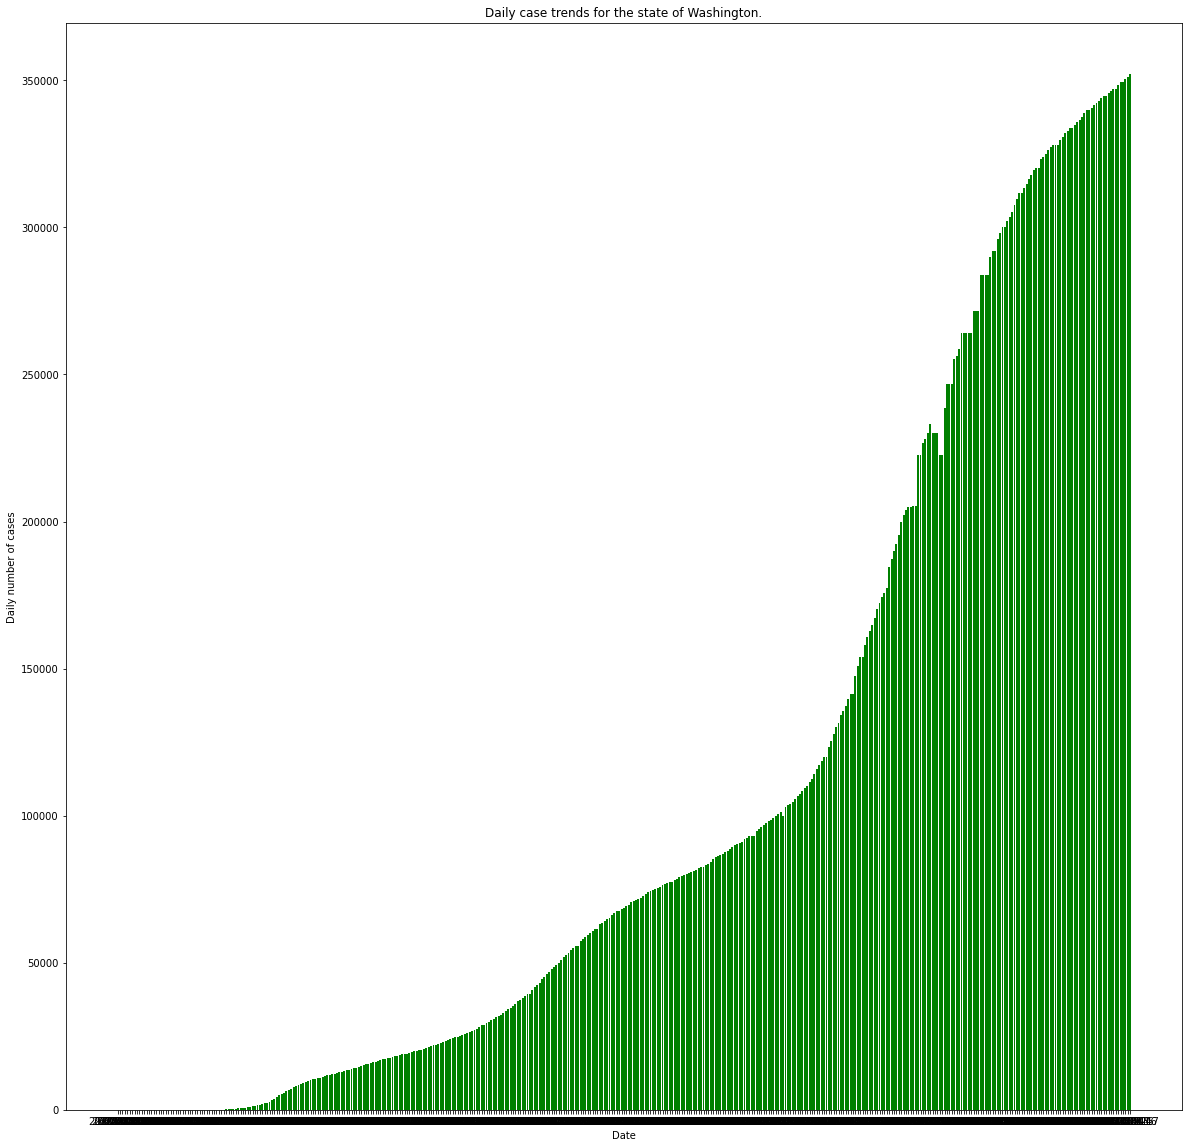

In [980]:
fig, ax = plt.subplots(figsize=(20,20))

ax.bar(daily_trends_cases['date'],
       daily_trends_cases['total_cases'],
       color='green')

ax.set(xlabel="Date",
       ylabel="Daily number of cases",
       title="Daily case trends for the state of Washington.")

plt.show()

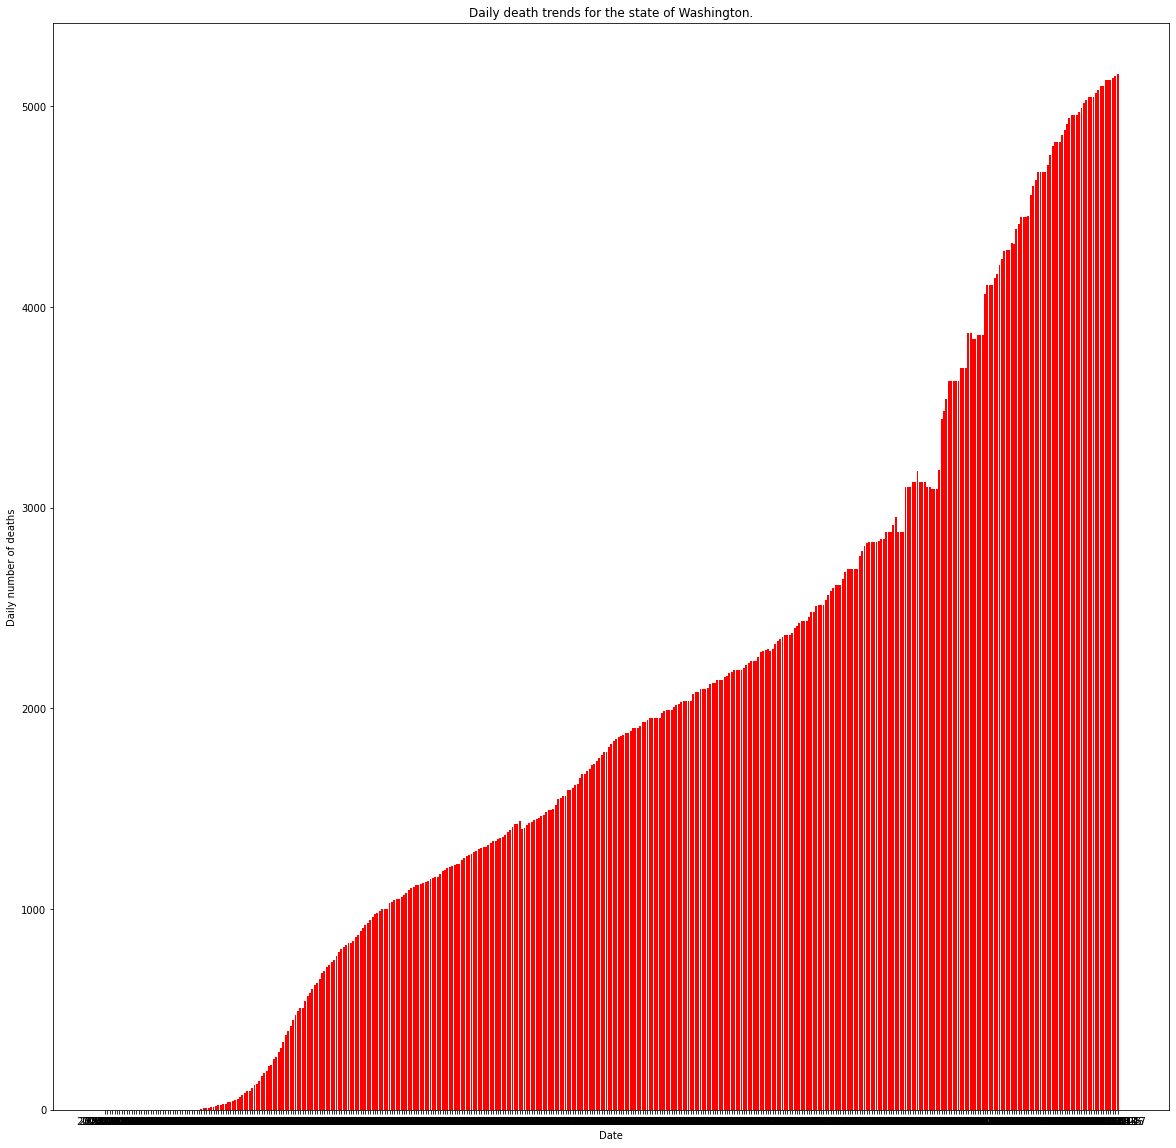

In [981]:
fig, ax = plt.subplots(figsize=(20,20))

ax.bar(daily_trends_deaths['date'],
       daily_trends_deaths['total_deaths'],
       color='red')

ax.set(xlabel="Date",
       ylabel="Daily number of deaths",
       title="Daily death trends for the state of Washington.")

plt.show()

# Task 2


## Fit a distribution to the number of COVID-19 new cases of a state of your choosing.

## -Graphically plot the distribution and describe the distribution statistics. If using discrete values, calculate the Probability Mass Function for the individual values or range (if using histogram) and plot that.
## -Describe the type of distribution (modality) and its statistics (moments of a distribution - center, variance, skewness, kurtosis) in the report and the notebook.
## -Compare the distribution and its statistics to 5 other states of your choosing.

Below are 12 histograms. 2 for each state.

For WA

In [982]:
temp = (main_data_wa_norm['total_cases']/w_population)*100000
mean_wa = temp.mean()
var_wa = temp.var()
std_wa = stat.stdev(temp)
skew_wa = skew(temp)
kurtosis_wa = kurtosis(temp)
median_wa = temp.median()
print('Printing all stats for cases \nmean - {}\n skewness - {}\n variance - {}\n kurtosis - {}\n standard deviation - {}\n median - {}'.format(mean_wa,skew_wa,var_wa, kurtosis_wa, std_wa,median_wa))

figure1 = px.histogram(temp, x='total_cases', nbins = 20, title = "Histogram of Cases of Washington")
figure1.show()

Printing all stats for cases 
mean - 2.911679933984756
 skewness - 2.331748336901452
 variance - 38.66087259527502
 kurtosis - 4.523661355381754
 standard deviation - 6.217786792362297
 median - 0.013132160885254724


We can see that the histograms are skewed which is the result of lower boundary in the dataset. It shows mean is larger. The kurtosis is also high here. And we have very high standard deviation.

In [983]:
temp = (main_data_wa_norm['total_deaths']/w_population)*100000
mean_wa_deaths = temp.mean()
var_wa_deaths = temp.var()
std_wa_deaths = stat.stdev(temp)
skew_wa_deaths = skew(temp)
kurtosis_wa_deaths = kurtosis(temp)
median_wa_deaths = temp.median()
print('Printing all stats for deaths \nmean - {}\n skewness - {}\n variance - {}\n kurtosis - {}\n standard deviation - {}\n median - {}'.format(mean_wa_deaths,skew_wa_deaths,var_wa_deaths, kurtosis_wa_deaths, std_wa_deaths,median_wa_deaths))

figure2 = px.histogram(temp, x='total_deaths', nbins = 20, title = "Histogram of Deaths of Washington")
figure2.show()

Printing all stats for deaths 
mean - 0.17653068730998153
 skewness - 1.9794740209206796
 variance - 0.10613099149522055
 kurtosis - 2.9609274978666464
 standard deviation - 0.3257775184005498
 median - 0.0


We have similar kind of histograms here. which are skewed

For PA

In [984]:
temp = (main_data_pa_norm['total_cases_pa']/p_population)*100000
mean_pa = temp.mean()
var_pa = temp.var()
std_pa = stat.stdev(temp)
skew_pa = skew(temp)
kurtosis_pa = kurtosis(temp)
median_pa = temp.median()
print('Printing all stats for cases \nmean - {}\n skewness - {}\n variance - {}\n kurtosis - {}\n standard deviation - {}\n median - {}'.format(mean_pa,skew_pa,var_pa, kurtosis_pa, std_pa,median_pa))

figure3 = px.histogram(temp, x='total_cases_pa', nbins = 30, title = "Histogram of Cases of Pennsylvania")
figure3.show()

Printing all stats for cases 
mean - 0.2347227475970246
 skewness - 3.698644731888096
 variance - 0.4659022048248967
 kurtosis - 13.77312720447032
 standard deviation - 0.6825702929551628
 median - 0.0


In [985]:
temp = (main_data_pa_norm['total_deaths_pa']/p_population)*100000
mean_pa_deaths = temp.mean()
var_pa_deaths = temp.var()
std_pa_deaths = stat.stdev(temp)
skew_pa_deaths = skew(temp)
kurtosis_pa_deaths = kurtosis(temp)
median_pa_deaths = temp.median()
print('Printing all stats for deaths \nmean - {}\n skewness - {}\n variance - {}\n kurtosis - {}\n standard deviation - {}\n median - {}'.format(mean_pa_deaths,skew_pa_deaths,var_pa_deaths, kurtosis_pa_deaths, std_pa_deaths,median_pa_deaths))

figure4 = px.histogram(temp, x='total_deaths_pa', nbins = 20, title = "Histogram of Deaths of Pennsylvania")
figure4.show()

Printing all stats for deaths 
mean - 0.0008963771048440656
 skewness - 3.693376373542963
 variance - 1.0369418436853999e-05
 kurtosis - 12.90873233320582
 standard deviation - 0.0032201581384854374
 median - 0.0


For CA

In [986]:
temp = (main_data_ca_norm['total_cases_ca']/c_population)*100000
mean_ca = temp.mean()
var_ca = temp.var()
std_ca = stat.stdev(temp)
skew_ca = skew(temp)
kurtosis_ca = kurtosis(temp)
median_ca = temp.median()
print('Printing all stats for cases \nmean - {}\n skewness - {}\n variance - {}\n kurtosis - {}\n standard deviation - {}\n median - {}'.format(mean_ca,skew_ca,var_ca, kurtosis_ca, std_ca,median_ca))

figure5 = px.histogram(temp, x='total_cases_ca', nbins = 20, title = "Histogram of Cases of California")
figure5.show()

Printing all stats for cases 
mean - 0.5384928400593373
 skewness - 2.6346173020597226
 variance - 1.384792658179721
 kurtosis - 6.236026640029802
 standard deviation - 1.1767721351985359
 median - 0.03037034894240195


In [987]:
temp = (main_data_ca_norm['total_deaths_ca']/c_population)*100000
mean_ca_deaths = temp.mean()
var_ca_deaths = temp.var()
std_ca_deaths = stat.stdev(temp)
skew_ca_deaths = skew(temp)
kurtosis_ca_deaths = kurtosis(temp)
median_ca_deaths = temp.median()
print('Printing all stats for deaths \nmean - {}\n skewness - {}\n variance - {}\n kurtosis - {}\n standard deviation - {}\n median - {}'.format(mean_ca_deaths,skew_ca_deaths,var_ca_deaths, kurtosis_ca_deaths, std_ca_deaths,median_ca_deaths))

figure6 = px.histogram(temp, x='total_deaths_ca', nbins = 20, title = "Histogram of Cases of California")
figure6.show()

Printing all stats for deaths 
mean - 0.01140962562726849
 skewness - 2.569558730779523
 variance - 0.0003771895785405247
 kurtosis - 6.061606173102078
 standard deviation - 0.019421369121164576
 median - 0.005061724823733659


For GA

In [988]:
temp = (main_data_ga_norm['total_cases_ga']/g_population)*100000
mean_ga = temp.mean()
var_ga = temp.var()
std_ga = stat.stdev(temp)
skew_ga = skew(temp)
kurtosis_ga = kurtosis(temp)
median_ga = temp.median()
print('Printing all stats for cases \nmean - {}\n skewness - {}\n variance - {}\n kurtosis - {}\n standard deviation - {}\n median - {}'.format(mean_ga,skew_ga,var_ga, kurtosis_ga, std_ga,median_ga))

figure7 = px.histogram(temp, x='total_cases_ga', nbins = 20, title = "Histogram of Cases of Georgia")
figure7.show()

Printing all stats for cases 
mean - 0.4227508492563529
 skewness - 3.4081132612124176
 variance - 1.4401239512336923
 kurtosis - 10.920209039899126
 standard deviation - 1.200051645236026
 median - 0.0


In [989]:
temp = (main_data_ga_norm['total_deaths_ga']/g_population)*100000
mean_ga_deaths = temp.mean()
var_ga_deaths = temp.var()
std_ga_deaths = stat.stdev(temp)
skew_ga_deaths = skew(temp)
kurtosis_ga_deaths = kurtosis(temp)
median_ga_deaths = temp.median()
print('Printing all stats for deaths \nmean - {}\n skewness - {}\n variance - {}\n kurtosis - {}\n standard deviation - {}\n median - {}'.format(mean_ga_deaths,skew_ga_deaths,var_ga_deaths, kurtosis_ga_deaths, std_ga_deaths,median_ga_deaths))

figure8 = px.histogram(temp, x='total_deaths_ga', nbins = 20, title = "Histogram of Deaths of Georgia")
figure8.show()

Printing all stats for deaths 
mean - 0.010962494630095347
 skewness - 3.856044868162597
 variance - 0.0015085656468104619
 kurtosis - 13.7038125713526
 standard deviation - 0.03884025806827835
 median - 0.0


For IA

In [990]:
temp = (main_data_ia_norm['total_cases_ia']/i_population)*100000
mean_ia = temp.mean()
var_ia = temp.var()
std_ia = stat.stdev(temp)
skew_ia = skew(temp)
kurtosis_ia = kurtosis(temp)
median_ia = temp.median()
print('Printing all stats for cases \nmean - {}\n skewness - {}\n variance - {}\n kurtosis - {}\n standard deviation - {}\n median - {}'.format(mean_ia,skew_ia,var_ia, kurtosis_ia, std_ia,median_ia))

figure9 = px.histogram(temp, x='total_cases_ia', nbins = 20, title = "Histogram of Cases of Iowa")
figure9.show()

Printing all stats for cases 
mean - 0.22913939141512904
 skewness - 3.011840643419031
 variance - 0.29920884454896957
 kurtosis - 9.527550767693715
 standard deviation - 0.5469998579058037
 median - 0.0


In [991]:
temp = (main_data_ia_norm['total_deaths_ia']/i_population)*100000
mean_ia_deaths = temp.mean()
var_ia_deaths = temp.var()
std_ia_deaths = stat.stdev(temp)
skew_ia_deaths = skew(temp)
kurtosis_ia_deaths = kurtosis(temp)
median_ia_deaths = temp.median()
print('Printing all stats for deaths \nmean - {}\n skewness - {}\n variance - {}\n kurtosis - {}\n standard deviation - {}\n median - {}'.format(mean_ia_deaths,skew_ia_deaths,var_ia_deaths, kurtosis_ia_deaths, std_ia_deaths,median_ia_deaths))

figure10 = px.histogram(temp, x='total_deaths_ia', nbins = 20, title = "Histogram of Deaths of Iowa")
figure10.show()

Printing all stats for deaths 
mean - 0.0
 skewness - 0.0
 variance - 0.0
 kurtosis - -3.0
 standard deviation - 0.0
 median - 0.0


For MA

In [992]:
temp = (main_data_ma_norm['total_cases_ma']/m_population)*100000
mean_ma = temp.mean()
var_ma = temp.var()
std_ma = stat.stdev(temp)
skew_ma = skew(temp)
kurtosis_ma = kurtosis(temp)
median_ma = temp.median()
print('Printing all stats for cases \nmean - {}\n skewness - {}\n variance - {}\n kurtosis - {}\n standard deviation - {}\n median - {}'.format(mean_ma,skew_ma,var_ma, kurtosis_ma, std_ma,median_ma))

figure11 = px.histogram(temp, x='total_cases_ma', nbins = 20, title = "Histogram of Cases of Massachussets")
figure11.show()

Printing all stats for cases 
mean - 0.8127148213446254
 skewness - 2.887611001977339
 variance - 3.59358852330073
 kurtosis - 8.27215532051133
 standard deviation - 1.8956762707014954
 median - 0.014508517442792551


In [993]:
temp = (main_data_ma_norm['total_deaths_ma']/m_population)*100000
mean_ma_deaths = temp.mean()
var_ma_deaths = temp.var()
std_ma_deaths = stat.stdev(temp)
skew_ma_deaths = skew(temp)
kurtosis_ma_deaths = kurtosis(temp)
median_ma_deaths = temp.median()
print('Printing all stats for deaths \nmean - {}\n skewness - {}\n variance - {}\n kurtosis - {}\n standard deviation - {}\n median - {}'.format(mean_pa_deaths,skew_pa_deaths,var_pa_deaths, kurtosis_pa_deaths, std_pa_deaths,median_pa_deaths))

figure12 = px.histogram(temp, x='total_deaths_ma', nbins = 20, title = "Histogram of Deaths of Massachusetts")
figure12.show()

Printing all stats for deaths 
mean - 0.0008963771048440656
 skewness - 3.693376373542963
 variance - 1.0369418436853999e-05
 kurtosis - 12.90873233320582
 standard deviation - 0.0032201581384854374
 median - 0.0


For the normalized data, we see a lot of data near 0 and the modality of the distribution is skewed.

## Model a poission distribution of COVID-19 cases and deaths of a state and compare to other 5 states. For example, number of new cases and deaths per 100,000 population. Hint - the parameter for a poission's distribution will be its mean value. Then for the minimum and maximum range of covid cases you are calculating probability mass function to observe the probability at different points.

Getting the mean here.

In [994]:
mu1 = (total_cases_sum['mean_cases'].sum()/w_population)*100000
mu2 = (total_cases_sum_pa['mean_cases_pa'].sum()/p_population)*100000
mu3 = (total_cases_sum_ca['mean_cases_ca'].sum()/c_population)*100000
mu4 = (total_cases_sum_ga['mean_cases_ga'].sum()/g_population)*100000
mu5 = (total_cases_sum_ia['mean_cases_ia'].sum()/i_population)*100000
mu6 = (total_cases_sum_ma['mean_cases_ma'].sum()/m_population)*100000

mu7 = (total_deaths_sum['mean_deaths'].sum()/w_population)*100000
mu8 = (total_deaths_sum_pa['mean_deaths_pa'].sum()/p_population)*100000
mu9 = (total_deaths_sum_ca['mean_deaths_ca'].sum()/c_population)*100000
mu10 = (total_deaths_sum_ga['mean_deaths_ga'].sum()/g_population)*100000
mu11 = (total_deaths_sum_ia['mean_deaths_ia'].sum()/i_population)*100000
mu12 = (total_deaths_sum_ma['mean_deaths_ma'].sum()/m_population)*100000

getting the poission distribution for cases.

In [995]:
x = np.arange(0,600,100)
temp = { 'Washington' : poisson.pmf(x, mu1), 'Pennsylvania': poisson.pmf(x,mu2),'California': poisson.pmf(x,mu3),'Georgia': poisson.pmf(x,mu4),'Iowa': poisson.pmf(x,mu5),'Massachussets' : poisson.pmf(x,mu6)}
temp_dataframe = pd.DataFrame(data=temp)
fig = px.scatter(temp_dataframe, x=x, y = ['Washington', 'Pennsylvania', 'California', 'Georgia', 'Iowa', 'Massachussets'], title = 'Poisson Distribution for cases').update_traces(mode='lines+markers')
fig.show()

Getting the poisson distribution for deaths.

In [996]:
x = np.arange(0,600,100)
temp = { 'Washington' : poisson.pmf(x, mu7), 'Pennsylvania': poisson.pmf(x,mu8),'California': poisson.pmf(x,mu9),'Georgia': poisson.pmf(x,mu10),'Iowa': poisson.pmf(x,mu11),'Massachussets' : poisson.pmf(x,mu12)}
temp_dataframe = pd.DataFrame(data=temp)
fig = px.scatter(temp_dataframe, x=x, y = ['Washington', 'Pennsylvania', 'California', 'Georgia', 'Iowa', 'Massachussets'], title = 'Poisson Distribution for deaths').update_traces(mode='lines+markers')
fig.show()

## Model poission distributions for North Carolina counties COVID-19 in cases and deaths. For example, number of new cases and deaths per 100,000 populations.

## Perform corelation between Enrichment data valiables and COVID-19 cases to observe any patterns.

## -> You can compare either within your chosen specific state or among different states with the different enrichment variables. Within the state you can compare the county based covid data to enrichment data for correlation. Between states you would need to aggregate to state level data and then perform correlation. Both covid and enrichment data will need to be normalized for population. For number of covid cases you can use a measure of center value (median or mean) to compare the number of cases.

Here, I am trying to see the relation between the number of beds and the population of a state.

In [999]:

beds.fillna(0)
beds_total = beds.groupby("HQ_STATE").sum()[['NUM_LICENSED_BEDS']].reset_index()

super_dataset.fillna(0)
new_super = super_dataset.groupby("State").sum()[['population']]

getting the tables ready.

In [1000]:
final_correlation = beds_total.merge(new_super, left_on= 'HQ_STATE', right_on= 'State')

Normalizing the data.

In [1001]:
final_correlation['normalized bed/population'] = (final_correlation.NUM_LICENSED_BEDS/final_correlation.population)*100000

In [1002]:
final_correlation

,HQ_STATE,NUM_LICENSED_BEDS,population,normalized bed/population
0,AK,1832.0,731545,250.428887
1,AL,18611.0,4903185,379.569606
2,AR,12473.0,3017804,413.313787
3,AZ,18388.0,7278717,252.626940
4,CA,80768.0,39512223,204.412695
5,CO,13813.0,5758736,239.861664
6,CT,8126.0,3565287,227.919940
7,DC,4262.0,705749,603.897420
8,DE,3125.0,973764,320.919648
9,FL,62201.0,21477737,289.606861


In [1003]:
final_correlation['NUM_LICENSED_BEDS'].corr(final_correlation['population'])

0.9694420670293435

We can see that there is a lot of correlation between number of licensed beds and the population in each and every state. I wanted to see how many beds were there per person. It looks like we have about 1 bed for 300 people in a state which is not enough.

## Formulate hypothesis between Enrichment data and number of cases to be compared against states. Choose 3 different variables to compare against.

## -> For example: Does higher employment data lead to higher covid case numbers or more rapid increase in covid cases.

Looking at the correlation and data we have,

-Is number of beds a direct factor while fighting with covid? Does death rates rise where state have low number of beds?

-Does it matter that states can add temporary beds when needed? will that help with the cases and deaths?

-Does number of licensed beds have to do anything with the cases of that state? Does having higher beds lead to higher number of cases due to the development/number of hospitals in the state? 
